# New Transfer Learning Tensorflow

We will use a technique called <i><b>Transfer Learning</b></i> where:
- we take a pre-trained network (trained on about a million general images), 
- use it to extract features, 
- and train a new layer on top for our own task of classifying images of flowers

In [1]:
# IMPORT IMPORTANTI

import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# GIA' FATTO
# pip install tensorflow_hub

# 1) Taking the flower dataset

In [2]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
    #If the images aren't already downloaded, save them to FLOWERS_DIR.
    if not os.path.exists(FLOWERS_DIR):
        DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        print('Downloading flower images from %s...' % DOWNLOAD_URL)
        urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
        !tar xfz flower_photos.tgz
    print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random(RANDOM_SEED)
    is_root = True
    for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            #print(label_to_class)
            is_root = False
        # The sub directories give us the image files for training.
        else:
            #print(dirname)
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            #print(full_filenames)
            label = dirname.split('\\')[-1]
            #print(label)
            label_class = label_to_class[label]
            #print(label_class)
            # An example is the image file and it's label class.
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            #print(examples)
            num_train = int(len(filenames) * TRAIN_FRACTION)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])

    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    return train_examples, test_examples, classes


In [3]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


In [5]:
# PROBLEMA RISOLTO TRAMITE L'UTILIZZO DI TALE METODO
# DA NON RUNNARE ANCHE SE COMUNQUE NON INFICIA NELLA RISOLUZIONE
prova = 'flower_photos\daisy'
wrong_labbel = prova.split('/')
labbel = prova.split('\\')[-1]
labbel

'daisy'

# 2) Explore the data

The flowers dataset consists of examples which are labeled images of flowers. Each example contains a JPEG flower image and the class label: what type of flower it is. <i>Let's display a few images together with their labels</i>

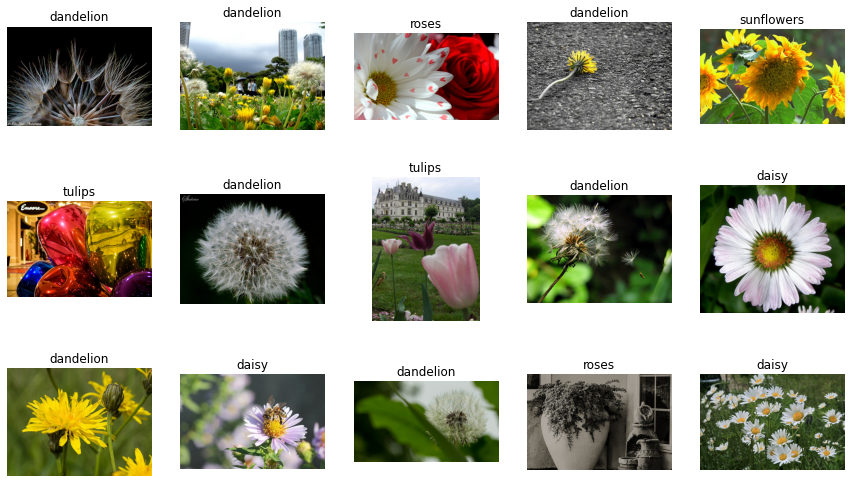

In [4]:

def get_label(example):
    """Get the label (number) for given example."""
    return example[1]

def get_class(example):
    """Get the class (string) of given example."""
    return CLASSES[get_label(example)]

def get_encoded_image(example):
    """Get the image data (encoded jpg) of given example."""
    image_path = example[0]
    return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
    """Get image as np.array of pixels for given example."""
    return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, flower_class) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_class)

NUM_IMAGES = 15 
display_images([(get_image(example), get_class(example)) for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

# 3) Build the model

We will load a <i>TF-Hub</i> image feature vector module, stack a linear classifier on it, and add training and evaluation ops. <i><b>The following cell builds a TF graph describing the model and its training, but it doesn't run the training (that will be the next step)</b></i>.

Quindi i passaggi sono i seguenti:
- Carichiamo una immagine <i><b>TH-Hub</b></i> che mi prende un modello pre-addestrato, al cui interno precisamente abbiamo un classificatore lineare
- Aggiungiamo a tale modelloo le operazioni di training e di valutazione

### Va comunque ricordato che tale cella crea un grafo descrivente il modello ed il suo training, ma non runna il training

In [27]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')
# NUOVO image_module DA UTILIZZARE QUANDO SI CAMBIA IL TUTTO
# image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)
# Tale metodo:
# - decodifica in tensori le immagini
# - converte le immagini in numeri (pixel)
# - mi ridimensiona le immagini tramite il metodo sopra scritto "get_expected_image_size"
def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)

# Tale metodo mi applica il metodo "decode_and_resize_image" in "encoded_images"
batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.

# ATTENZIONE
# ATTENZIONE
# ATTENZIONE
# QUESTA E' IL MODO PER ESTRARRE FEATURES ED UTILIZZARLE ALL'INTERNO DI UN NUOVO MODELLO 
features = image_module(batch_images)


def create_model(features):
    """Build a model for classification from extracted features."""
    # Currently, the model is just a single linear layer. You can try to add
    # another layer, but be careful... two linear layers (when activation=None)
    # are equivalent to a single linear layer. You can create a nonlinear layer
    # like this:
    # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
    layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
    return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# 4) Train the Network

Now that our model is built, let's train it and see how it perfoms on our test set.

In [28]:
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 
# How often to evaluate the model performance.
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    batch_examples = random.sample(examples, batch_size) if batch_size else examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
        # Run the train_op to train the model.
        train_loss, _, train_accuracy = sess.run(
            [cross_entropy_mean, train_op, accuracy],
            feed_dict={encoded_images: batch_images, labels: batch_labels})
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size=None, test=True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
              [cross_entropy_mean, accuracy, prediction, correct_prediction],
              feed_dict={encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 19.57%
Test accuracy at step 10: 48.51%
Test accuracy at step 20: 60.33%
Test accuracy at step 30: 69.02%
Test accuracy at step 40: 71.88%
Test accuracy at step 50: 73.51%
Test accuracy at step 60: 76.09%
Test accuracy at step 70: 78.12%
Test accuracy at step 80: 79.76%
Test accuracy at step 90: 79.21%
Test accuracy at step 99: 79.08%


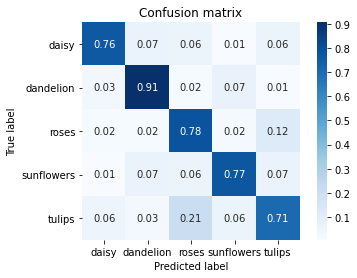

In [29]:
def show_confusion_matrix(test_labels, predictions):
    """Compute confusion matrix and normalize."""
    confusion = sk_metrics.confusion_matrix(np.argmax(test_labels, axis=1), predictions)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    axis_labels = list(CLASSES.values())
    ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

# 5) Watching incorrect predictions

Let's a take a closer look at the test examples that our model got wrong:
- Are there any mislabeled examples in our test set?
- Is there any bad data in the test set - images that aren't actually pictures of flowers?
- Are there images where you can understand why the model made a mistake?

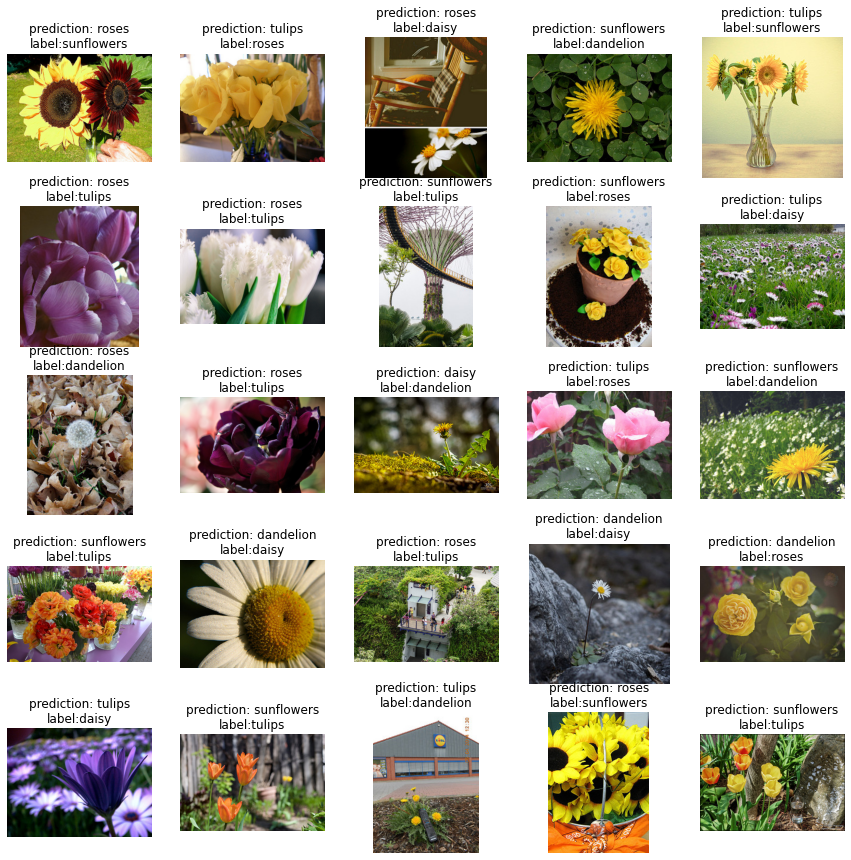

In [30]:
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:25]])

# Exercises

## Exercise 1: change the model taer from TF_Hub

In [31]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2')

encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)

def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# QUESTA E' IL MODO PER ESTRARRE FEATURES ED UTILIZZARLE ALL'INTERNO DI UN NUOVO MODELLO 
features = image_module(batch_images)


def create_model(features):
    """Build a model for classification from extracted features."""
    # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
    layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
    return layer

logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

probabilities = tf.nn.softmax(logits)

prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))
 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [32]:
NUM_TRAIN_STEPS = 100 
TRAIN_BATCH_SIZE = 10 
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    batch_examples = random.sample(examples, batch_size) if batch_size else examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
        # Run the train_op to train the model.
        train_loss, _, train_accuracy = sess.run(
            [cross_entropy_mean, train_op, accuracy],
            feed_dict={encoded_images: batch_images, labels: batch_labels})
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size=None, test=True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
              [cross_entropy_mean, accuracy, prediction, correct_prediction],
              feed_dict={encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 33.83%
Test accuracy at step 10: 55.30%
Test accuracy at step 20: 63.72%
Test accuracy at step 30: 72.55%
Test accuracy at step 40: 71.20%
Test accuracy at step 50: 74.73%
Test accuracy at step 60: 76.36%
Test accuracy at step 70: 75.95%
Test accuracy at step 80: 78.80%
Test accuracy at step 90: 79.08%
Test accuracy at step 99: 78.80%


## Exercise 2: Add an hidden layer 

In [36]:
LEARNING_RATE = 0.01
NEW_UNIT=100

tf.reset_default_graph()

image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2')

encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)

def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# QUESTA E' IL MODO PER ESTRARRE FEATURES ED UTILIZZARLE ALL'INTERNO DI UN NUOVO MODELLO 
features = image_module(batch_images)


def create_model(features):
    """Build a model for classification from extracted features."""
    # CAMBIO RISPETTO A PRIMA ATTENZIONE
    layer = tf.layers.dense(inputs=features, units=NEW_UNIT, activation=tf.nn.relu)
    layer = tf.layers.dense(inputs=layer, units=NUM_CLASSES, activation=None)
    return layer

logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

probabilities = tf.nn.softmax(logits)

prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))
 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
NUM_TRAIN_STEPS = 100 
TRAIN_BATCH_SIZE = 10 
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    batch_examples = random.sample(examples, batch_size) if batch_size else examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
        # Run the train_op to train the model.
        train_loss, _, train_accuracy = sess.run(
            [cross_entropy_mean, train_op, accuracy],
            feed_dict={encoded_images: batch_images, labels: batch_labels})
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size=None, test=True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
              [cross_entropy_mean, accuracy, prediction, correct_prediction],
              feed_dict={encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 29.89%
Test accuracy at step 10: 55.71%
Test accuracy at step 20: 64.13%
Test accuracy at step 30: 72.96%
Test accuracy at step 40: 72.55%
Test accuracy at step 50: 76.22%
Test accuracy at step 60: 78.12%
Test accuracy at step 70: 78.26%
Test accuracy at step 80: 78.94%
Test accuracy at step 90: 79.62%
Test accuracy at step 99: 80.57%


## Exercise 3: Changing Hyperparameters

Does increasing number of training steps improves final accuracy? Can you change the learning rate to make your model converge more quickly? Does the training batch size affect your model's performance?

Quindi possiamo cambiare:
- <i><b>number of training step</b></i>
- <i><b>Learning rate</b></i>
- <i><b>Grandezza del batch di training</b></i>

In [38]:
NUM_TRAIN_STEPS = 150 
TRAIN_BATCH_SIZE = 20 
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    batch_examples = random.sample(examples, batch_size) if batch_size else examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
        # Run the train_op to train the model.
        train_loss, _, train_accuracy = sess.run(
            [cross_entropy_mean, train_op, accuracy],
            feed_dict={encoded_images: batch_images, labels: batch_labels})
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size=None, test=True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
              [cross_entropy_mean, accuracy, prediction, correct_prediction],
              feed_dict={encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 20.38%
Test accuracy at step 10: 52.72%
Test accuracy at step 20: 64.13%
Test accuracy at step 30: 70.79%
Test accuracy at step 40: 73.78%
Test accuracy at step 50: 75.68%
Test accuracy at step 60: 77.99%
Test accuracy at step 70: 78.94%
Test accuracy at step 80: 79.35%
Test accuracy at step 90: 80.03%
Test accuracy at step 100: 79.89%
Test accuracy at step 110: 79.21%
Test accuracy at step 120: 81.39%
Test accuracy at step 130: 80.98%
Test accuracy at step 140: 82.07%
Test accuracy at step 149: 82.88%


## Exercize 4: Try a different Optimizer, like <i>AdagradOptimizer</i>

In [39]:
LEARNING_RATE = 0.01
NEW_UNIT=100

tf.reset_default_graph()

image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2')
imaga_modula = hub.Module('https://tfhub.dev/google/imagenet/inception_v1/feature_vector/4')

encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)

def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# QUESTA E' IL MODO PER ESTRARRE FEATURES ED UTILIZZARLE ALL'INTERNO DI UN NUOVO MODELLO 
features = image_module(batch_images)


def create_model(features):
    """Build a model for classification from extracted features."""
    # CAMBIO RISPETTO A PRIMA ATTENZIONE
    layer = tf.layers.dense(inputs=features, units=NEW_UNIT, activation=tf.nn.relu)
    layer = tf.layers.dense(inputs=layer, units=NUM_CLASSES, activation=None)
    return layer

logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

probabilities = tf.nn.softmax(logits)

prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))
 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [40]:
NUM_TRAIN_STEPS = 150 
TRAIN_BATCH_SIZE = 20 
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
    """Get a random batch of examples."""
    examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
    batch_examples = random.sample(examples, batch_size) if batch_size else examples
    return batch_examples

def get_images_and_labels(batch_examples):
    images = [get_encoded_image(e) for e in batch_examples]
    one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
    return images, one_hot_labels

def get_label_one_hot(example):
    """Get the one hot encoding vector for the example."""
    one_hot_vector = np.zeros(NUM_CLASSES)
    np.put(one_hot_vector, get_label(example), 1)
    return one_hot_vector

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_TRAIN_STEPS):
        # Get a random batch of training examples.
        train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
        batch_images, batch_labels = get_images_and_labels(train_batch)
        # Run the train_op to train the model.
        train_loss, _, train_accuracy = sess.run(
            [cross_entropy_mean, train_op, accuracy],
            feed_dict={encoded_images: batch_images, labels: batch_labels})
        is_final_step = (i == (NUM_TRAIN_STEPS - 1))
        if i % EVAL_EVERY == 0 or is_final_step:
            # Get a batch of test examples.
            test_batch = get_batch(batch_size=None, test=True)
            batch_images, batch_labels = get_images_and_labels(test_batch)
            # Evaluate how well our model performs on the test set.
            test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
              [cross_entropy_mean, accuracy, prediction, correct_prediction],
              feed_dict={encoded_images: batch_images, labels: batch_labels})
            print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 33.02%
Test accuracy at step 10: 62.23%
Test accuracy at step 20: 73.78%
Test accuracy at step 30: 77.17%
Test accuracy at step 40: 81.79%
Test accuracy at step 50: 81.39%
Test accuracy at step 60: 83.15%
Test accuracy at step 70: 80.84%
Test accuracy at step 80: 82.74%
Test accuracy at step 90: 83.97%
Test accuracy at step 100: 84.51%
Test accuracy at step 110: 83.83%
Test accuracy at step 120: 85.73%
Test accuracy at step 130: 86.14%
Test accuracy at step 140: 85.33%
Test accuracy at step 149: 85.19%


# Exercise 5: My model
This il also a copy, except for the module taken: it's the Inception V1

In [12]:
LEARNING_RATE = 0.01
NEW_UNIT=100

tf.reset_default_graph()

image_module = hub.Module('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4')
# image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2')
#image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/4')

encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)

def decode_and_resize_image(encoded):
    decoded = tf.image.decode_jpeg(encoded, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# QUESTA E' IL MODO PER ESTRARRE FEATURES ED UTILIZZARLE ALL'INTERNO DI UN NUOVO MODELLO 
features = image_module(batch_images)


def create_model(features):
    """Build a model for classification from extracted features."""
    # CAMBIO RISPETTO A PRIMA ATTENZIONE
    layer = tf.layers.dense(inputs=features, units=NEW_UNIT, activation=tf.nn.relu)
    layer = tf.layers.dense(inputs=layer, units=NUM_CLASSES, activation=None)
    return layer

logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

probabilities = tf.nn.softmax(logits)

prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))
 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

NotFoundError: NewRandomAccessFile failed to Create/Open: C:\Users\david\AppData\Local\Temp\tfhub_modules\2a68087cf06d9e9e88f8d5b3de882b3464b7e2d4\tfhub_module.pb : Impossibile trovare il file specificato.
; No such file or directory